# Нейронна мережа для класифікації зображень
- тип - згорткова
- датасет для навчання - CIFAR-10 (60000 кольорових зображень розміром 32x32, розбитих на 10 класів по 6000 прикладів на клас)
- класифікація відбувається по класах: airplane, car, bird, cat, deer, dog, frog, horse, ship and trucks
- використано передвиборну мережу VGG16


#### Частина 1. Підготовка даних та створення згорткової моделі

#### 1.1. Завантаження і підготовка даних

In [1]:
from tensorflow import keras

from keras.datasets import cifar10

from keras.models import Sequential

from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import BatchNormalization, Dropout

import numpy as np

import matplotlib.pyplot as plt

In [2]:
# Розпакування даних з load_data на тренувальні та тестові дані, а також відповідні мітки (labels)
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

In [ ]:
# Вивід розмірів тренувальної і тестової вибірки
print('Розміри тренувальної вибірки:', x_train.shape, y_train.shape)
print('Розміри тестової вибірки:', x_test.shape, y_test.shape)

Розміри тренувальної вибірки: (50000, 32, 32, 3) (50000, 1)
Розміри тестової вибірки: (10000, 32, 32, 3) (10000, 1)


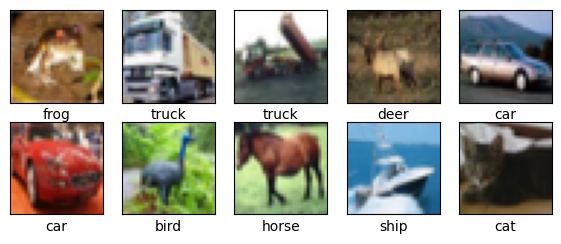

In [ ]:
# Покажемо, для загального уявлення, перщі 10 зображень з відповідними мітками з тренувальної вибірки
class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(7, 7))
for i in range(10):
    plt.subplot(5, 5, i + 1)  # визначає сітку 5x5 підзображень у великому зображенні
    plt.xticks([])  # вимикання координатних числових підписів
    plt.yticks([])
    plt.imshow(x_train[i])  # відображення картинки
    plt.xlabel(class_names[y_train[i][0]])  # підписування картинки міткою класу
plt.show()

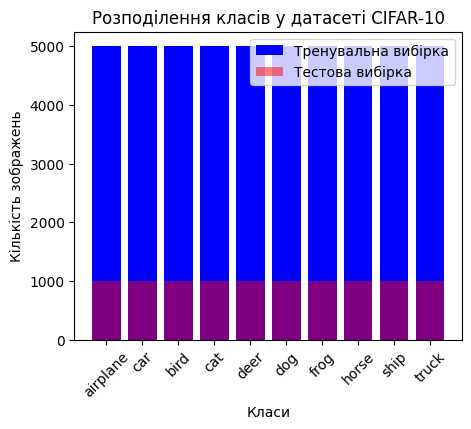

In [ ]:
# Проаналізуємо розподілення даних по класах для тренувальної та тестової вибірок
train_class_counts = np.bincount(y_train.flatten())  # кількість зображень у кожному класі для тренувальної вибірки
test_class_counts = np.bincount(y_test.flatten())  # кількість зображень у кожному класі для тестової вибірки

# Візуалізація розподілення класів
plt.figure(figsize=(5, 4))
plt.bar(np.arange(len(class_names)), train_class_counts, color='blue', label='Тренувальна вибірка')
plt.bar(np.arange(len(class_names)), test_class_counts, color='red', alpha=0.5, label='Тестова вибірка')
plt.xlabel('Класи')
plt.ylabel('Кількість зображень')
plt.title('Розподілення класів у датасеті CIFAR-10')
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.legend()
plt.show()

Як видно, датасет добре збалансований.

In [3]:
# Виконаємо нормалізацію даних перед їх передачею у згорткову модель
x_train, x_test = x_train / 255., x_test / 255.

#### 1.2. Створення згорткової моделі

In [ ]:
model = keras.Sequential()

model.add(Conv2D(32, (3, 3), padding='same',  activation='relu', kernel_initializer='he_normal', input_shape=(32, 32, 3)))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
# створюється 32 фільтри розміром (3,3), які рухаються по вхідному зображенню
# padding='same' вказує на додавання нулів до країв зображення
# kernel_initializer='he_normal' - ініціалізує ваги шару так, що дисперсія вихідних значень активацій зберігається після проходження через шар
# використовується пулінг з розміром (2, 2), що веде до зменшення розміру кожного зображення у два рази

model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.4))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

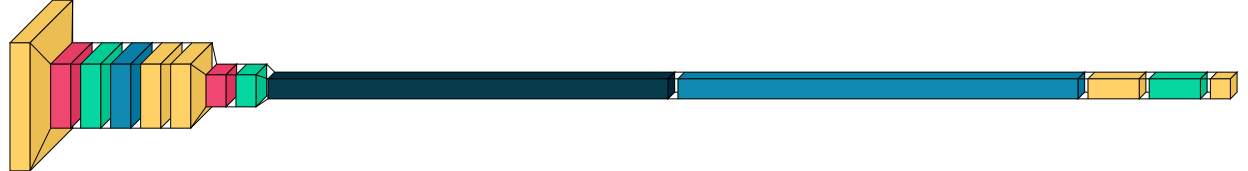

In [ ]:
# Візуалізуємо шарову структуру моделі
!pip install visualkeras

import visualkeras

visualkeras.layered_view(model)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 batch_normalization_2 (Bat  (None, 16, 16, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 128)       36992     
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)      

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
    )

In [ ]:
model_name = 'model_1'

history = model.fit(x_train, y_train,  batch_size=128, epochs=10, validation_split=0.2)

# Оцінка точності на тестових даних
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

Epoch 1/10
313/313 [==============================] - 366s 1s/step - loss: 1.7071 - sparse_categorical_accuracy: 0.4525 - val_loss: 3.0528 - val_sparse_categorical_accuracy: 0.2263
Epoch 2/10
313/313 [==============================] - 337s 1s/step - loss: 1.1155 - sparse_categorical_accuracy: 0.6036 - val_loss: 1.0108 - val_sparse_categorical_accuracy: 0.6464
Epoch 3/10
313/313 [==============================] - 333s 1s/step - loss: 0.9652 - sparse_categorical_accuracy: 0.6586 - val_loss: 0.8712 - val_sparse_categorical_accuracy: 0.7000
Epoch 4/10
313/313 [==============================] - 335s 1s/step - loss: 0.8570 - sparse_categorical_accuracy: 0.6983 - val_loss: 0.9852 - val_sparse_categorical_accuracy: 0.6742
Epoch 5/10
313/313 [==============================] - 334s 1s/step - loss: 0.7745 - sparse_categorical_accuracy: 0.7269 - val_loss: 0.8284 - val_sparse_categorical_accuracy: 0.7162
Epoch 6/10
313/313 [==============================] - 335s 1s/step - loss: 0.7020 - sparse_cate

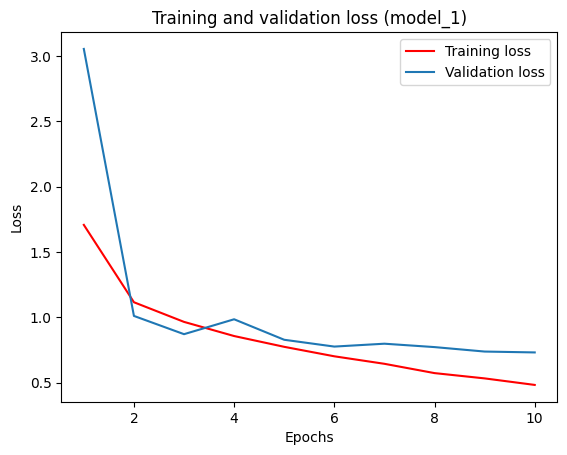

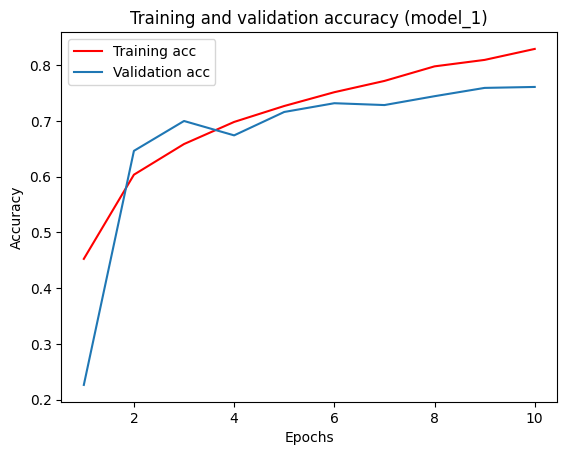

In [ ]:
# Візуалізуємо результати навчання

history_dict = history.history

epochs = range(1, len(history_dict['sparse_categorical_accuracy']) + 1)

plt.plot(epochs, history_dict['loss'], label='Training loss', color="r")
plt.plot(epochs, history_dict['val_loss'], label='Validation loss')
plt.title(f'Training and validation loss ({model_name})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
plt.plot(epochs, history_dict['sparse_categorical_accuracy'], label='Training acc', color="r")
plt.plot(epochs, history_dict['val_sparse_categorical_accuracy'], label='Validation acc')
plt.title(f'Training and validation accuracy ({model_name})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Точність моделі можна покращити. Для цього використаємо VGG16 в якості згорткової основи. Застосуємо прийоми донавчання та виділення ознак.

#### 1.3. Згорткова модель з попередньо навченою мережею VGG16
VGG16 очікує кольорові зображення розміром 32x32, тому для датасету CIFAR-10 не потрібно змінювати розмір вхідних даних.

#### 1.3.1. Виділення ознак (feature extraction)
Полягає в тому, щоб взяти основу попередньо навченої мережі, потім "прикріпити" до неї повнозв'язний класифікатор і навчити його на нових даних.

In [11]:
# Забезпечення сумісності даних CIFAR-10 з VGG16
from keras.utils import to_categorical

# Перетворення міток в категоріальний формат
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

In [5]:
from keras.applications.vgg16 import VGG16

# Створення VGG16 без верхнього повнозв'язаного шару
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
# weights='imagenet': ваги моделі повинні завантажуватися з попередньо навченої моделі на наборі даних ImageNet.
# ImageNet - це великий набір даних для розпізнавання об'єктів, який включає тисячі класів.
# Ваги, навчені на ImageNet, можуть бути використані як ефективний вихідний пункт для подальших завдань.
# include_top=False: верхні (fully connected) шари моделі (які відповідають за класифікацію в тисячах класів ImageNet)
# не повинні включатися. Ми  додаватимемо свій власний классифікатор поверх цієї згорткової основи, і тому верхні шари не потрібні.
# input_shape=(32, 32, 3): розмір вхідних зображень, які використовуються.
# У цьому випадку припускається, що вхідні зображення мають розмір 48x48 пікселів і три канали (RGB).

# Заморожуємо ваги базової моделі
conv_base.trainable = False

In [ ]:
# Створимо згорткову нейромережу, що використовує VGG16 як згортковий шар
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))  # Для 10 класів CIFAR-10

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),
    metrics=["accuracy"]
)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14848586 (56.64 MB)
Trainable params: 133898 (523.04 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
# Візуалізуємо шарову структуру моделі
!pip install visualkeras

import visualkeras

visualkeras.layered_view(model)

In [46]:
model_name = 'model_2'

history = model.fit(x_train, train_labels, epochs=10, batch_size=128, validation_split=0.5)

Epoch 1/10
196/196 [==============================] - 591s 3s/step - loss: 1.5618 - accuracy: 0.4799 - val_loss: 1.5544 - val_accuracy: 0.4791
Epoch 2/10
196/196 [==============================] - 590s 3s/step - loss: 1.5401 - accuracy: 0.4885 - val_loss: 1.5354 - val_accuracy: 0.4828
Epoch 3/10
196/196 [==============================] - 590s 3s/step - loss: 1.5208 - accuracy: 0.4930 - val_loss: 1.5179 - val_accuracy: 0.4878
Epoch 4/10
196/196 [==============================] - 589s 3s/step - loss: 1.5033 - accuracy: 0.4984 - val_loss: 1.5019 - val_accuracy: 0.4932
Epoch 5/10
196/196 [==============================] - 591s 3s/step - loss: 1.4874 - accuracy: 0.5024 - val_loss: 1.4877 - val_accuracy: 0.4968
Epoch 6/10
196/196 [==============================] - 589s 3s/step - loss: 1.4730 - accuracy: 0.5076 - val_loss: 1.4744 - val_accuracy: 0.4983
Epoch 7/10
196/196 [==============================] - 589s 3s/step - loss: 1.4595 - accuracy: 0.5116 - val_loss: 1.4630 - val_accuracy: 0.5020

In [47]:
# Оцінка точності на тестових даних
test_loss, test_acc = model.evaluate(x_test, test_labels)
print(f'Test accuracy: {test_acc}')

313/313 [==============================] - 109s 349ms/step - loss: 1.4462 - accuracy: 0.5063
Test accuracy: 0.5062999725341797


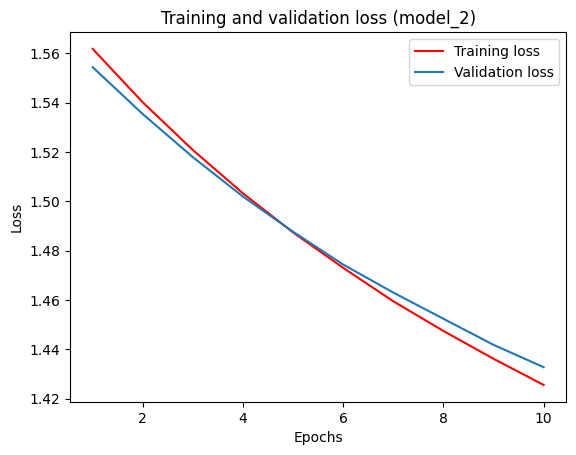

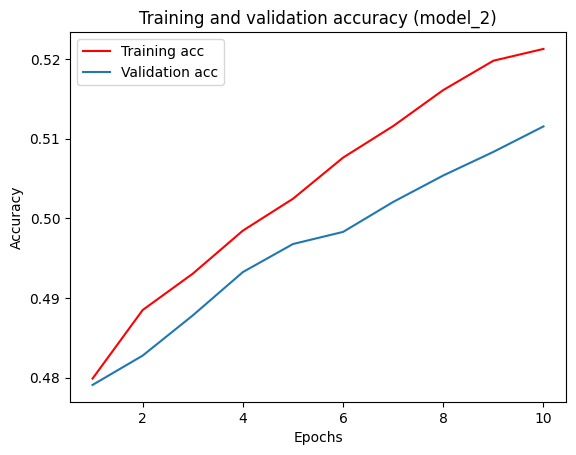

In [48]:
# Візуалізуємо результати навчання
history_dict = history.history

epochs = range(1, len(history_dict['loss']) + 1)

plt.plot(epochs, history_dict['loss'], label='Training loss', color="r")
plt.plot(epochs, history_dict['val_loss'], label='Validation loss')
plt.title(f'Training and validation loss ({model_name})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
plt.plot(epochs, history_dict['accuracy'], label='Training acc', color="r")
plt.plot(epochs, history_dict['val_accuracy'], label='Validation acc')
plt.title(f'Training and validation accuracy ({model_name})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Бачимо, що використання в якості основи згорткової мережі VGG16, при навчанні протягом 10 епох, дає точність ..............%. Далі застосуємо прийом донавчання.

#### 1.3.2. Донавчання нейромережі з основою VGG16
Цей підхід полягає в "розморожуванні" декількох верхніх шарів замороженої моделі, яка використовувалася для виділення ознак, і спільному навчанні нової доданої частини моделі (в даному випадку повнозв'язкового класифікатора) і цих верхніх шарів.

Для донавчання мережі потрібно виконати такі кроки:

- додати свою мережу поверх навченої базової мережі;
- заморозити базову мережу;
- навчити додану частину;
- розморозити кілька шарів у базовій мережі;
- навчити ці шари та додану частину разом.

Ми вже виконали перші три кроки, коли виділяли ознаки. Тепер виконаємо четвертий крок розморозивши кілька шарів у conv_base.

In [6]:
# Подивимося архітектуру нашої згорткової основи
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [7]:
# Виконаємо донавчання останніх трьох шарів, а саме: block5_conv1, block5_conv2 та block5_conv3.
# Інші шари залишимо без змін.
conv_base.trainable = True  # всі шари (layers) моделі conv_base тепер можна тренувати
set_trainable = False  # встановлює початкове значення змінної, яка буде використовуватися для визначення того, чи ми повинні тренувати певний шар
for layer in conv_base.layers:  # перебирає всі шари в моделі conv_base
    if layer.name == "block5_conv1":
        set_trainable = True  # якщо поточний шар має ім'я "block5_conv1", то встановлює змінну set_trainable в значення True (це означає, що всі наступні шари будуть тренуватися)
    if set_trainable:
        layer.trainable = True  # встановлюється можливість тренування для поточного шару
    else:
        layer.trainable = False  # поточний шар "заморожується"

In [8]:
# Створимо модифіковану згорткову нейромережу
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))  # Для 10 класів CIFAR-10

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),
    metrics=["accuracy"]
)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14848586 (56.64 MB)
Trainable params: 7213322 (27.52 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


In [58]:
# Візуалізуємо шарову структуру моделі
# !pip install visualkeras

import visualkeras

visualkeras.layered_view(model)

In [ ]:
model_name = 'model_cifar10_vgg16'

history = model.fit(x_train, train_labels, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15
  41/1250 [..............................] - ETA: 36:54 - loss: 1.0621 - accuracy: 0.6364

In [ ]:
# Оцінка точності на тестових даних
test_loss, test_acc = model.evaluate(x_test, test_labels)
print(f'Test accuracy: {test_acc}')

In [ ]:
# Збереження навченої моделі
model.save("model_cifar10_vgg16")

In [ ]:
# Візуалізуємо результати навчання
history_dict = history.history

epochs = range(1, len(history_dict['loss']) + 1)

plt.plot(epochs, history_dict['loss'], label='Training loss', color="r")
plt.plot(epochs, history_dict['val_loss'], label='Validation loss')
plt.title(f'Training and validation loss ({model_name})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
plt.plot(epochs, history_dict['accuracy'], label='Training acc', color="r")
plt.plot(epochs, history_dict['val_accuracy'], label='Validation acc')
plt.title(f'Training and validation accuracy ({model_name})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Наведемо Confusion Matrix для розуміння якості моделі по різних класах.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

# Завантаження попередньо навченої моделі
from keras.models import load_model
model = load_model('model_cifar10_vgg16')

# Отримання прогнозованих класів для тестового набору
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)

In [ ]:
# Побудова Confusion Matrix
conf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), y_pred)

# Візуалізація Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Отримання і вивід іншої важливої інформації
print("\nClassification Report:")
print(classification_report(np.argmax(test_labels, axis=1), y_pred))

# Висновки